In [1]:
import torch
from trak import TRAKer
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
from diffusion_trak import DiffusionModelOutput
from diffusion_trak import DiffusionGradientComputer
from diffusers import DDPMScheduler

# local import
from utils import get_cifar_model, get_cifar_dataloader

/mnt/xfs/home/krisgrg/conda_envs/h100/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/xfs/home/krisgrg/conda_envs/h100/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# CIFAR-10 unconditional model

In [2]:
model = get_cifar_model(sample_size=32, n_channels=3)
model.eval();

In [8]:
def load_checkpoints_from_dir(ckpt_dir) -> list:
    ckpts = []
    ckpt_dir = Path(ckpt_dir)
    for ckpt_path in sorted(list(ckpt_dir.iterdir())):
        ckpts.append(torch.load(ckpt_path))
    return ckpts


In [19]:
checkpoints = load_checkpoints_from_dir('../checkpoints')
model.load_state_dict(checkpoints[0])

<All keys matched successfully>

In [20]:
loader_train = get_cifar_dataloader(batch_size=16, split='train')

## Generate a sample trajectory with DDPM

We'll now generate a sample $x_0$ by running the DDPM sampler for a thousand iterations, starting from $x_{1000}$ and iteratively denoising the latent image.

In [21]:
# fixing the seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# drawing the random sample x_1000
input = torch.randn((1, 3, 32, 32)).to("cuda")
noise_scheduler = DDPMScheduler()

trajectory = []

for t in tqdm(noise_scheduler.timesteps):
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    d = noise_scheduler.step(noisy_residual, t, input)
    previous_noisy_sample = d.prev_sample
    x_0_hat = d.pred_original_sample
    input = previous_noisy_sample
    trajectory.append(x_0_hat.detach().clone().cpu())

# flip the order so trajectory[0] gives us the final image
trajectory = torch.stack(trajectory[::-1])

100%|██████████| 1000/1000 [00:11<00:00, 86.95it/s]


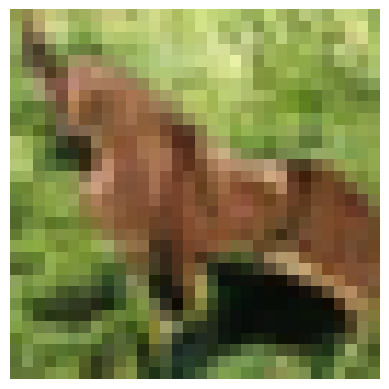

In [29]:
plt.imshow((trajectory[0, 0].permute([1, 2, 0]) + 1) / 2); plt.axis('off'); plt.show()

This is effectively the same as running the `DDPMPipeline`. We do the above in order to get access to the full trajectory of intermediate latents $x_t$, in addition to the final image $x_0$

## Attribute the sample trajectory at a timestep of choice

Here we choose to set the timestep $t=300$. Thus, we feed the latent $x_{300}$ to our `TRAKer` instance.

In [6]:
task = DiffusionModelOutput()

traker = TRAKer(model=model,
                task=task,
                gradient_computer=DiffusionGradientComputer,
                proj_dim=2048,
                train_set_size=len(loader_train.dataset),
                save_dir='../trak_results/',
                device='cuda')

                             Report any issues at https://github.com/MadryLab/trak/issues
ERROR:TRAK:Could not use CudaProjector.
Reason: /mnt/xfs/home/krisgrg/conda_envs/h100/lib/python3.9/site-packages/fast_jl.cpython-39-x86_64-linux-gnu.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
ERROR:TRAK:Defaulting to BasicProjector.
INFO:STORE:Existing model IDs in /mnt/xfs/home/krisgrg/projects/attributing-diffusion-models/trak_results: [0]
INFO:STORE:Model IDs that have been finalized: [0]
INFO:STORE:Existing TRAK scores:
INFO:STORE:debug: /mnt/xfs/home/krisgrg/projects/attributing-diffusion-models/trak_results/scores/debug.mmap


In [7]:
exp_name = "debug"
num_resamplings = 10

In [11]:
timestep = torch.tensor(300)

bs = trajectory.shape[1]

for model_id in tqdm(range(len(checkpoints))):
    ckpt = checkpoints[model_id]
    traker.start_scoring_checkpoint(exp_name=exp_name,
                                    checkpoint=ckpt,
                                    model_id=model_id,
                                    num_targets=bs)

    # images, labels, tstep, n_iters
    batch = [trajectory.permute([1, 0, 2, 3, 4]),
             torch.zeros(bs),
             timestep,
             num_resamplings
            ]
    traker.score(batch=batch, num_samples=bs)

scores = traker.finalize_scores(exp_name=exp_name, allow_skip=True)

Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]
INFO:STORE:Saving scores in /mnt/xfs/home/krisgrg/projects/attributing-diffusion-models/trak_results/scores/debug.mmap


In [12]:
scores

memmap([[ 1.0085e-04],
        [ 2.3484e-05],
        [-2.3580e-04],
        ...,
        [-4.4203e-04],
        [-9.6917e-05],
        [ 2.4462e-04]], dtype=float16)

# Analyze scores

In [43]:
top_inds = torch.tensor(scores).reshape(-1).argsort()[-5:]

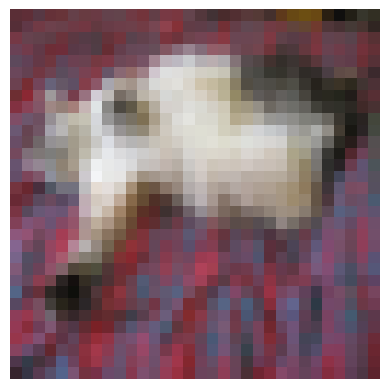

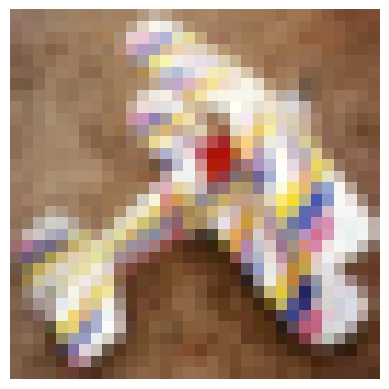

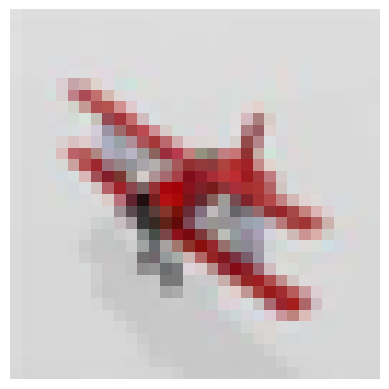

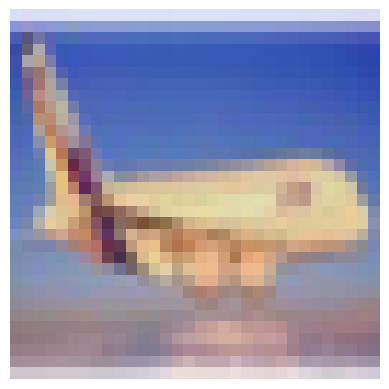

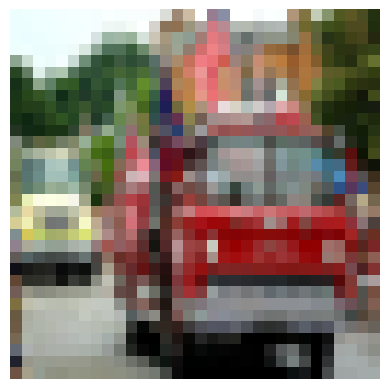

In [46]:
for idx in top_inds:
    plt.imshow((loader_train.dataset[idx.item()]['images'].permute([1, 2, 0]) + 1) / 2); plt.axis('off'); plt.show()